# Introduction


Here we present show how to calculate the merger rate densities and observed probabilities
for a population of double compact object mergers using the ClassCosmicIntegrator

In reality this class is one major for loop to redo the calculation at a single redshift for different redshifts and a range of metallicities (see earlier notes).

It combines all the classes/modules that we presented in the cosmic integration notes
In addition it stores the results into several 2D arrays for easy plotting/binning
already taking into account selection effects and volumes of the different redshift shells.

Here we show:

- How to set up the entire pipeline. The code specifically raises warnings/statements
    to help to remind you. This is simply a summary of the previous notes in the Cosmic Integration section.


- How to calculate the rate and plot the results using the 2D arrays in the ClassCosmicIntegrator

- How to loop over variations efficiently to create different distributions

# Paths

In [1]:
import os

pathNoteBook    = os.getcwd()
pathScripts     = pathNoteBook + '/PythonScripts/'


pathData        = "/home/cneijssel/Desktop/Test/"

# Imports

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
#custom scripts
sys.path.append(pathScripts)
import ClassCosmicIntegrator #this imports other routines by itself


# 1  Instance of Cosmic integrator class

The main thing that needs to be defined in this class is the universe and the
number of shells for which we want to calculate the merger rate densities. In addition we also set the GW-detector here

To this end, the following variables need to be defined in the instance (showing their default values)

    #For Data
    pathCOMPAS         = None
    
    #Defining Universe
    Cosmology          = 'WMAP'
    hubbleConstant     = 67.8
    omegaMatter        = 0.308
    redshiftFirstSFR   = 10.
    
    #Defining integral
    minRedshift        = 0.0
    maxRedshift        = 2.
    nrRedshiftBins     = 20
    
    #Method for calculating redshift from age
    RedshiftTabulated  = True
    RedshiftTabulatedResolution = 100000
    
    #Detector
    GWdetector_sensitivity      = 'O1'
    GWdetector_snrThreshold     = 8
    
    #Print steps
    verbose   = False

pathCOMPAS: 
    
    path to the h5-data. 
    
Cosmology:

    Which of the astropy cosmology settings to use. Currently it takes either
    'WMAP' or you set it to 'Custom Flat'. If you do the latter you need to 
    set the hubbleConstant and omegaMatter. In the case of 'WMAP' these are
    ignored and a predefined setting is used
    
hubbleconstant:
    
    see Cosmology
    
omegaMatter:
    
    see Cosmology
    
redshiftFirstSFR:
    
    the highest redshift at which we assume the first stars are born.
    Any star born at a higher redshift gets a rate of zero.
    
minRedshift:
    
    to lowest limit/edge of the redshift bins for the integral
    
maxRedshift:
    
    the upper limit/edge of the redshfit bins for the integral
    
nrRedshiftBins:
    
    number of bins in which to resolve the integral. 

RedshiftTabulated:

    Boolean. Method to calculate redshift of universe based on age. The functions
    are slow and hence looking it up in a predefined table is quicker and still sub-percent 
    precision. If true we use the table method. If False we use an alternative function,
    which might be more precise but it is order of magnitude slower.
    
RedshiftTabulatedResolution:
    
    Resolution of table (in from 0- to redshift first SFR) to calculate ages
    Hence the default tabulated method has a precision of dz = 1/10000
    
    
GWdetector_sensitivity:

    The sensitivity curve assumed to estimate the signal-to-noise of a system
    
GWdetector_snrThreshold:

    The single detecter signal-to-noise limit above which we define a system
    to be detectable

verbose:

    to print some intermediate output/messages during calculation


# Creating all the instances

In [3]:
#using the defaults
CI = ClassCosmicIntegrator.CosmicIntegrator(pathCOMPAS=pathData)

reminders of what to set in the following order:

ClassCOMPAS: Remember to self.setGridAndMassEvolved()
                   then  self.setCOMPASDCOmask()
                   then  self.setCOMPASData()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassCosmicIntegrator: Remember to setBirthTimesAnd2Darrays()
                        to prepare calculation/results
                        do you have the GW-detector you want?



### classCOMPAS

In [4]:
#Info python Submit and assumptions to recover Msun evovled
CI.COMPAS.Mlower = 5.
CI.COMPAS.Mupper = 150.
CI.COMPAS.binaryFraction = 0.7
CI.COMPAS.setGridAndMassEvolved()
# which DCOs I want
CI.COMPAS.setCOMPASDCOmask(types='BBH', optimistic=True) 
# Get me the data
CI.COMPAS.setCOMPASData()

Warning no RLOF_SECONDARY_POST_COMMON_ENVELOPE column
I will not mask the data for this
Warning no Optimistic_Common_Envelope column
I will not mask the data for this


### classMSSFR


In [5]:
# Pick the SFR model
CI.MSSFR.SFRprescription = 'Neijssel et al. (2019)'
#metallicity
CI.MSSFR.Zprescription = 'logNormal'
CI.MSSFR.logNormalPrescription ='Neijssel Phenomenological'

#Use the grid of the simulation
CI.MSSFR.metallicityGrid = CI.COMPAS.metallicityGrid
CI.MSSFR.calculateMetallicityBinEdges()


### classCosmicIntegrator


In [6]:
#Use the COMPAS data and redshift grid to define 2D arrays and precalculate
#values needed for quick integration. This takes a bit. That is why we do it outside
#all other functions. Say you want to calculate the rates for three different
#SFR models. These values don't change 
#(they only change when the redshift shells or the data changes)
#Hence you do it once.
CI.setBirthTimesAnd2Darrays()

# 2 Calculate and plot

In [7]:
# everthing is set so now so calculate :)
CI.cosmologicalIntegration()

It stores the results in several different 2D arrays, below is directly copied from source code

They are 2D arrays where each row is a redshift and each column is a single system

In [8]:
print(CI.PerSystemPerRedshift_ratesIntrinsic.shape)
print(CI.nrRedshiftBins)
print(len(CI.COMPAS.delayTimes))

(20, 77)
20
77


This means that each cell is the rate of a single system at a single redshift.
Now you can add rows/columns according to your interest. Examples:

## Example rate in shell, rate as function of redshift

In [9]:
#central redshift in the shell 
redshifts = CI.Shell_centerRedshift
print(redshifts)

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95]


In [10]:
#intrinsic merger rate of all systems at redshift of interest
# say I want to know it in the 10th shell which is centered around
#central redshift in the shell 
print(CI.Shell_centerRedshift[10])
TotalIntrinsicRateAtSHell = np.sum(CI.PerSystemPerRedshift_ratesIntrinsic[10])
print(TotalIntrinsicRateAtSHell)

1.05
161.25774091895076


Text(0, 0.5, 'rate Intrinsic [dN/dGpc3/dYr]')

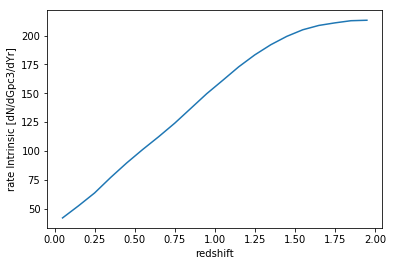

In [11]:
# Plot the intrinsic rate in shell
z         = CI.Shell_centerRedshift
#Now use numpy to just collapse all values
rate      = np.sum(CI.PerSystemPerRedshift_ratesIntrinsic, axis=1)

fig, axes = plt.subplots(1,1)
axes.plot(z, rate)
axes.set_xlabel('redshift')
axes.set_ylabel('rate Intrinsic [dN/dGpc3/dYr]')

## Example mask rate by mass and get observed rate

The columns in the 2D array relate to the individual systems. They are ordered the same
as the systems in the classCOMPAS. Hence we can use the parameters in the classCOMPAS
to create a mask for our result!!! (hence the lazy data :) )

Now a detector looks at all redshift simultaneously so lets sum the rate of each system from every shell in the detector frame. I.e. collapse to array of length number systems

In [12]:
ratePerSystemObserved = np.sum(CI.PerSystemPerRedshift_ratesObserved, axis=0)
print(len(ratePerSystemObserved))

77


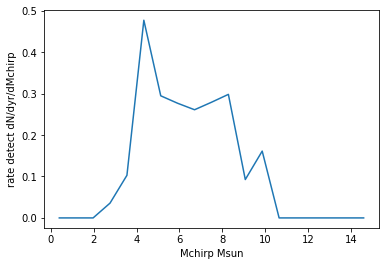

In [13]:
# plot chirp mass distribution

chirpMass  = CI.COMPAS.mChirp
#for every chirpmass I know the rate at which you observe
ratePerSystemObserved = np.sum(CI.PerSystemPerRedshift_ratesObserved, axis=0)

#I only want systems with chirp masses below 10 Msun (for some reason)
mask      = chirpMass < 10


binsMchirp = np.linspace(0,15,20)
dMchirp    = np.diff(binsMchirp)
center     = (binsMchirp[1:]+binsMchirp[:-1])/2.

yvalues, _ = np.histogram(chirpMass[mask], bins=binsMchirp, \
                          weights=ratePerSystemObserved[mask])

dydMchirp  = np.divide(yvalues, dMchirp)

fig, axes = plt.subplots(1,1)
axes.plot(center, dydMchirp)
axes.set_xlabel('Mchirp Msun')
axes.set_ylabel('rate detect dN/dyr/dMchirp')
plt.show()

# 3 - Loop over the cosmic Integrator

Once the class is set you could quickly change prescription or DCO
type and recalculate without having to redo the entire instance.
This especially saves time in terms of reading/setting the COMPASdata
and preparing the 2D arrays in the classCosmicIntegrator. The exception being 
if you loop over the data or change the redshift shells. We provide an example in both cases

In [14]:
# loop over prescriptions using the already defined class

#data and redshift shells remain unchanged
SFRprescriptions = ['Madau et al. (2014)',\
                    'Madau et al. (2017)',\
                    'Strolger et al. (2004)',\
                    'Neijssel et al. (2019)']

for SFRprescription in SFRprescriptions:
    #change SFR
    CI.MSSFR.SFRprescription = SFRprescription
    #calculate the result
    CI.cosmologicalIntegration()
    #print the total observed rate
    observedRate = np.round(np.sum(CI.PerSystemPerRedshift_ratesObserved))
    print('total predicted rate for %s for SFR=%s mergers per year' \
          %(CI.GWdetector_sensitivity, observedRate))

total predicted rate for O1 for SFR=36.0 mergers per year
total predicted rate for O1 for SFR=24.0 mergers per year
total predicted rate for O1 for SFR=33.0 mergers per year
total predicted rate for O1 for SFR=24.0 mergers per year


In [15]:
# loop over prescriptions using the already defined class

#careful the SFR is still the one of the previous cell!

#loop over DCO types changing the Data 
#This takes longer

types = ['BBH', 'BHNS', 'BNS']

for t in types:
    
    # which DCOs I want
    CI.COMPAS.setCOMPASDCOmask(types=t, optimistic=True) 
    # Get me the data
    CI.COMPAS.setCOMPASData()
    
    #the number of systems and their delay times have changed 
    #reset arrays results. Note that this goes considerably faster
    #then the first time we do this, because we dont recalculate
    #the redshift table if it is already done :) :) :)
    CI.setBirthTimesAnd2Darrays()
    
    #calculate
    CI.cosmologicalIntegration()

    #print the total observed rate
    observedRate = np.round(np.sum(CI.PerSystemPerRedshift_ratesObserved))
    print('------total predicted rate for %s =%s mergers per year' \
          %(t, observedRate))

Warning no RLOF_SECONDARY_POST_COMMON_ENVELOPE column
I will not mask the data for this
Warning no Optimistic_Common_Envelope column
I will not mask the data for this
------total predicted rate for BBH =24.0 mergers per year
Warning no RLOF_SECONDARY_POST_COMMON_ENVELOPE column
I will not mask the data for this
Warning no Optimistic_Common_Envelope column
I will not mask the data for this
------total predicted rate for BHNS =0.0 mergers per year
Warning no RLOF_SECONDARY_POST_COMMON_ENVELOPE column
I will not mask the data for this
Warning no Optimistic_Common_Envelope column
I will not mask the data for this
------total predicted rate for BNS =0.0 mergers per year


Note that his means that if you want to loop over 
both DCO types and SFR prescriptions, it is more time-efficient
to loop over types first and then SFR prescriptions.

With this you should be all set. good luck
For more info on how to create plots using this pipeline see
the plotting library in the postProcessing notes :)
    
    